### Initialization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.models as models
import pandas as pd
import numpy as np
import random, time, os, math

from useful_things.dataloader import *
from useful_things.networks import *
from useful_things.helper_functions import *
from useful_things.vis_utils import *

from transforms.hog import *

If you need to resize images...

In [2]:
# # Resizes all images in folder to 3x224x224 to use in pytorch pretrained models
# resizeImages('images/sorted_data/noUtility/')
# resizeImages('images/sorted_data/noVeg/')
# resizeImages('images/sorted_data/veg/')

### Define model
Next we load pretrained models, see https://pytorch.org/docs/stable/torchvision/models.html for a list of pretrained models to choose from. For different networks, print the model first to find out which layer number is the last one and how many nodes it has

In [3]:
# CHOOSE MODEL:
model_name = 'vgg11_bn'
use_Image = True
use_HoG = True
use_HOUGH = True

In [4]:
# DON'T CHANGE:
def freeze_gradients(model):
    'freezes gradients of all parameters in model'
    for param in model.parameters():
        param.requires_grad = False
    return model

if model_name == 'resnet18':
    model = models.resnet18(pretrained=True)
    model = freeze_gradients(model)
    model.fc = nn.Linear(512,3, bias=True)
    
elif model_name == 'vgg11_bn':
    model = models.vgg11_bn(pretrained=True)
    model = freeze_gradients(model)
    model.classifier[0] = nn.Linear(25088, 4096, bias=True)  # initializes requires_grad = True
    model.classifier[2] = nn.Dropout(p=0.7)
    model.classifier[3] = nn.Linear(4096, 4096, bias=True)  # initializes requires_grad = True
    model.classifier[5] = nn.Dropout(p=0.7)
    model.classifier[6] = nn.Linear(4096,3, bias=True)  # initializes requires_grad = True
    
elif model_name == 'alexnet':
    model = models.alexnet(pretrained=True)
    model = freeze_gradients(model)
    model.classifier[6] = nn.Linear(4096,3, bias=True)

if use_HoG:
    model = addWeightsToLayer1(model, model_name)
    
if use_HOUGH:
    model = addWeightsToLayer1(model, model_name)
    
if not use_Image:
    model = removeImageWeights(model, model_name)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

### Set up data
Note only the first and last layers of the model now will be trained - all other layers are frozen. This next cell creates the data loaders for the train, dev, and test sets. Only thing to tweak here is batch size. Other than that, leave alone. Since we don't want to do the HoG/HOUGH transform at every instance during training, we will save the training set transforms to be loading by our dataloader.

In [5]:
N = {}
N['noUtil'] = len(os.listdir('images/sorted_data/noUtility/'))
N['noVeg'] = len(os.listdir('images/sorted_data/noVeg/'))
N['Veg'] = len(os.listdir('images/sorted_data/veg/'))

random.seed(2)
partition = partitionDataset(N, ratio=(80, 10, 10))

performTransforms = False  # only run once
print('Making train set with %d images'%len(partition['train']))
train_set = UtilityDataset(partition['train'], use_Image, use_HoG, use_HOUGH, 'train', performTransforms=performTransforms)

print('Making dev set with %d images'%len(partition['dev']))
dev_set = UtilityDataset(partition['dev'], use_Image, use_HoG, use_HOUGH, 'dev', performTransforms=performTransforms)

print('Making test set with %d images'%len(partition['test']))
test_set = UtilityDataset(partition['test'], use_Image, use_HoG, use_HOUGH, 'test', performTransforms=performTransforms)

N_train = len(train_set)
N_dev = len(dev_set)
N_test = len(test_set)

params = {'batch_size': 32,
         'shuffle': True,
         'num_workers': 4}

train_generator = DataLoader(train_set, **params)
dev_generator = DataLoader(dev_set, **params)
test_generator = DataLoader(test_set, **params)

Making train set with 1055 images
Making dev set with 134 images
Making test set with 131 images


## Train
Some fixed model parameters (CUDA takes like ~30 seconds on first run)...

In [6]:
# define loss function - the weights parameters offsets imbalance in number if images of each class
class_weights = [1.0, N['noUtil']/N['noVeg'], N['noUtil']/N['Veg']]
class_weights = torch.FloatTensor(class_weights).cuda()
loss_fcn = nn.CrossEntropyLoss(weight=class_weights)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.cuda()
print('cuda succesful' if use_cuda else 'cpu')

cuda succesful


Tunable parameters...

In [7]:
alpha = 1e-4           # this is the initial learning rate
weight_decay = 1e-3    # this is the regularization term in the ADAM optimzater
max_epochs = 11
start_epochs = 5      # number of epochs where learning rate is constant
decay_epochs = max_epochs - start_epochs

Run training loop...

In [8]:
# initialize some performance parameters:
best_accuracy = 0
train_loss_history, train_accuracy_history, dev_accuracy_history, lr_history = [], [], [], []

print('Starting training...')
print(' #  | Loss / Time  | Accuracy')

optimizer = optim.Adam(model.parameters(), lr=alpha, weight_decay=weight_decay)
for epoch in range(max_epochs):
    tic = time.time()
    
    if epoch > start_epochs:
        # update learning rate
        lr = 0.5*alpha*(1+math.cos((epoch-start_epochs)*math.pi/decay_epochs))
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        lr = alpha
    lr_history.append(lr)

    # train:
    model.train()
    running_loss = 0.
    correct_predictions = 0
    for batch, (imgs, labels) in enumerate(train_generator):
        imgs, labels = imgs.to(device), labels.to(device)   # bring data onto GPU
        
        # run model forward for unflipped to calculate loss and prediction accuracy
        scores = model(imgs)
        loss = loss_fcn(scores,labels)
        pred_class = scores.argmax(1)
        correct_predictions += (pred_class == labels).sum().item()

        # run model forward with flipped imgs
        scores = model(torch.flip(imgs,[3]))
        loss += loss_fcn(scores,labels)
        pred_class = scores.argmax(1)
        correct_predictions += (pred_class == labels).sum().item()
        
        running_loss += loss*labels.shape[0]
        
        # perform weight updates
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    running_loss /= (2*N_train) # calculate average training loss for epoch
    train_accuracy = 100 * correct_predictions/(2*N_train)   # divide by 2 because data was augmented
    print('E-%d | loss = %.2f  | train accuracy = %.2f%%'%(epoch+1, running_loss, train_accuracy))
    train_loss_history.append(running_loss)
    train_accuracy_history.append(train_accuracy)
    
    # development:
    model.eval()
    correct_predictions = 0
    for imgs, labels in dev_generator:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # run model to calculate prediction accuracy
        scores = model(imgs)
        pred_class = scores.argmax(1)
        correct_predictions += (pred_class == labels).sum().item()

        # run model on flipped data to calculate prediction accuracy
        scores = model(torch.flip(imgs,[3]))
        pred_class = scores.argmax(1)
        correct_predictions += (pred_class == labels).sum().item()

    dev_accuracy = 100 * correct_predictions/(2 * N_dev)
    toc = time.time()
    print('E-%d | %.1f seconds | dev accuracy = %.2f%%'%(epoch+1,toc-tic,dev_accuracy))
    dev_accuracy_history.append(dev_accuracy)
    
    if dev_accuracy >= best_accuracy:
        best_accuracy = dev_accuracy
        torch.save(model,'best_model_' + model_name)

print('Best dev acc: ', best_accuracy)

Starting training...
 #  | Loss / Time  | Accuracy
E-1 | loss = 0.99  | train accuracy = 54.08%
E-1 | 47.1 seconds | dev accuracy = 66.42%
E-2 | loss = 0.63  | train accuracy = 70.09%
E-2 | 44.4 seconds | dev accuracy = 71.27%
E-3 | loss = 0.53  | train accuracy = 75.17%
E-3 | 42.3 seconds | dev accuracy = 75.75%
E-4 | loss = 0.41  | train accuracy = 81.85%
E-4 | 43.5 seconds | dev accuracy = 76.49%
E-5 | loss = 0.24  | train accuracy = 88.53%
E-5 | 43.0 seconds | dev accuracy = 78.73%
E-6 | loss = 0.18  | train accuracy = 92.13%
E-6 | 42.6 seconds | dev accuracy = 79.85%
E-7 | loss = 0.16  | train accuracy = 92.56%
E-7 | 42.1 seconds | dev accuracy = 80.22%
E-8 | loss = 0.13  | train accuracy = 94.69%
E-8 | 42.9 seconds | dev accuracy = 78.73%
E-9 | loss = 0.08  | train accuracy = 96.64%
E-9 | 40.7 seconds | dev accuracy = 81.72%
E-10 | loss = 0.04  | train accuracy = 98.20%
E-10 | 43.1 seconds | dev accuracy = 79.85%
E-11 | loss = 0.04  | train accuracy = 98.39%
E-11 | 40.8 seconds |

In [9]:
# pd.read_csv('vgg_train_accuracy_history.csv').values.max()

In [10]:
# pd.read_csv('vgg_dev_accuracy_history.csv').values.max()

#### Plot training

In [16]:
np.savetxt('vgg11_lr-1e-4_drop7_80+_train_loss_history.csv', np.array(train_loss_history), delimiter=',')
np.savetxt('vgg11_lr-1e-4_drop7_80+_train_accuracy_history.csv', np.array(train_accuracy_history), delimiter=',')
np.savetxt('vgg11_lr-1e-4_drop7_80+_dev_accuracy_history.csv', np.array(dev_accuracy_history), delimiter=',')

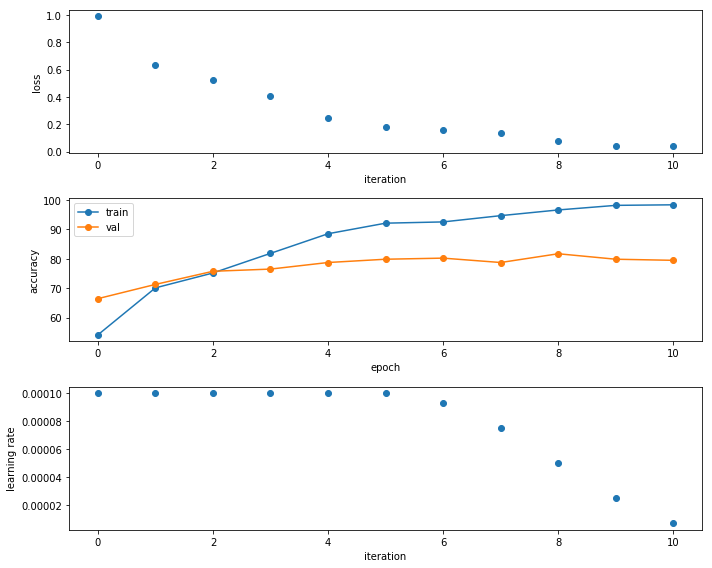

In [12]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(train_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(3, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(dev_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(3, 1, 3)
plt.plot(lr_history, 'o')
plt.xlabel('iteration')
plt.ylabel('learning rate')

plt.tight_layout()
plt.show()

## Test

In [13]:
model_name = 'vgg11_bn'
# model_name = 'vgg16_bn_broke'
# model_name = 'vgg16_bn_V2'
# model_name = 'vgg11_bn'
# model_name = 'vgg11_bn_drop5'

model = torch.load('best_model_' + model_name)
model.eval()

confusionMatrix = torch.zeros(3,3)

# test:
correct_predictions = 0
for imgs, labels in test_generator:
    imgs, labels = imgs.to(device), labels.to(device)
    
    # run model to calculate prediction accuracy
    scores = model(imgs)
    pred_class = scores.argmax(1)
    correct_predictions += (pred_class == labels).sum().item()
   
    # start confusion matrix
    for i in range(labels.shape[0]):
        confusionMatrix[labels[i],pred_class[i]] += 1

    # run model on flipped data to calculate prediction accuracy
    scores = model(torch.flip(imgs,[3]))
    pred_class = scores.argmax(1)
    correct_predictions += (pred_class == labels).sum().item()
    
    # finish confusion matrix
    for i in range(labels.shape[0]):
        confusionMatrix[labels[i],pred_class[i]] += 1

        test_accuracy = 100 * correct_predictions/(2 * N_test)
print('Test Set Accuracy = %.2f%%'%(test_accuracy))

print('\nConfusion Matrix - rows are correct class, columns are predicted:')
print(confusionMatrix)
print('0 - no Utility')
print('1 - no Veg')
print('2 - veg')

Test Set Accuracy = 80.15%

Confusion Matrix - rows are correct class, columns are predicted:
tensor([[114.,  12.,   4.],
        [ 26.,  84.,   4.],
        [  5.,   1.,  12.]])
0 - no Utility
1 - no Veg
2 - veg


### Visualize Network

(64, 5, 3, 3)


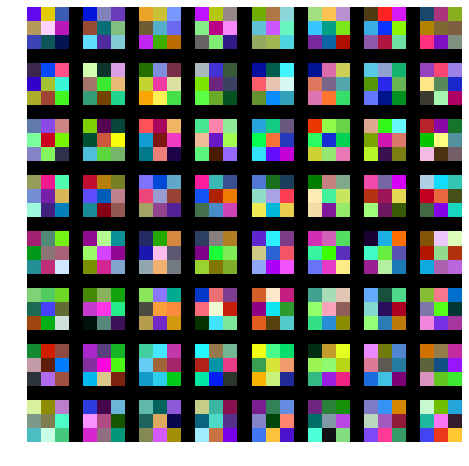

In [15]:
layer1_name = list(model.state_dict().keys())[0]
layer1_weights = model.state_dict()[layer1_name].cpu().numpy()
print(layer1_weights.shape)

grid = visualize_grid(layer1_weights[:,:3].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(8, 8)
plt.show()